# Blogging with RNNs 2.0: Transfer Learning

By Karl Heyer

This is a follow up to my first attempt at using blogs from the [Blog Authorship Corpus](http://u.cs.biu.ac.il/~koppel/BlogCorpus.htm) to first create a language model, then use that language model in a classification model to classify blog authors by gender. My [first attempt](https://github.com/kheyer/ML-DL-Projects/blob/master/Blog%20RNN%20Text%20Classification/Blog%20Classification%20RNN.ipynb) at doing this didn't work out well. The final model had about 50% accuracy - it was literally as good as flipping a coin.

The main reason for failure was that I was trying to train a full language model from scratch, but had to limit the total amount of data I used for the language model due to time and memory constraints. This created a crappy language model that in turn led to a crappy classification model.

This time around we're going to improve things by jump starting the model with a pretrained model. The language model we will start with is the wikitext103 LM created by Stephen Merity at Salesforce research ([link](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)). The exact weights used in this project are provided by [fast.ai](http://files.fast.ai/models/wt103/).

How exactly this works and why it improves performance is discussed in the Model Architecture section.

## Contents

1. Model Architecture
2. Project Setup
3. Language Model Training
4. Text Classification

# 1. Model Architecture

This project will use a recurrent neural network (RNN) to build a language model. Lets break down what these mean.

## Language Model

This model will try to predict the next word in a string of words. For example, if the last sequence of words the RNN has seen were "The sky is", it should predict "blue" as the next character.

This is different from a character level model that tries to predict one character at a time.

The fundamental way we will represent language in this model is through a word embedding matrix representing the vocabulary of our corpus. When we process text for feeding into the model, each word is mapped to a number value. Each word/number in the corpus has a corresponding row of weights in the embedding matrix. This creates a higher dimensional representation of the word. When the RNN processes sentences of text, it is really processing vectors of weight values for each word.


## Recurrent Neural Network

Most deep learning architectures have a series of layers that process an input into an output. Each layer has a set of weights that perform some functional operation to convert inputs to outputs. RNNs, rather than having a deep stack of layers, have a single hidden layer that is updated every time an input comes in. This allows the activations of a previous input to affect the activations of the next input. This allows RNNs to learn complex relationships along a series of inputs.

This has made RNNs very effective architectures for NLP problems, where understanding a word in a sentence requires understanding what came before it.

For example, lets say the RNN is processing the sentence "The sky is blue". Since this is a word level language model, each word (represented by a vector of weights from the embedding matrix) is fed into the network one word/vector at a time.

First the netword processes "The" and updates the hidden state accordingly.
Then the network processes "sky", using the activations generated by the previous word "the" to process "sky" and generate a new set of activations. 
Then the network processes "is" using the activations generated by processing "sky" and "the". And so on.


In Pytorch, the standard RNN module processes each input into a new set of activations using the following equation:

$h_t = tanh(w_{ih} x_t + b_{ih}  +  w_{hh} h_{(t-1)} + b_{hh})$

The network starts with an existing hidden state $h_{(t-1)}$. When a new input $x_t$ enters the network, it is processed by a linear layer with weights $w_{ih}$ and bias $b_{ih}$. The hidden state $h_{(t-1)}$ is also processed by a linear layer with weights $w_{hh}$ and bias $b_{hh}$. The outputs of these two linear layers are summed together and processed by the $tanh$ activation function to create the new hidden state $h_t$.

For this project, we'll use a more advanced version of an RNN called an LSTM. The key improvement of LSTMs over regular RNNs is LSTMs introduce a set of gates that control how much information from the old hidden state and the current input move into the new hidden state. The parameters that control these gates are learned by the network. This allows LSTMs to learn and understand information over longer periods.

The equations governing LSTMs:

$\begin{array}{ll}
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
c_t = f_t c_{(t-1)} + i_t g_t \\
h_t = o_t \tanh(c_t)
\end{array}$

$i_{t}$ is the input gate. This controls how much of the new input is taken into the cell state.

$f_{t}$ is the forget gate. This gate controls how much of the old cell state passes on to the new cell state.

$g_{t}$ is the cell gate, which is the same equation we used to define our new hidden state in the standard RNN.

$o_{t}$ is the output gate which controls how much of the cell state passes on to the hidden state.

$c_{t}$ is the current cell state. You will notice $c_{t}$ is composed of the old cell state, the current forget gate, the current input gate, and the current cell gate. This shows how the various gates are used to filter how much of the input and previous cell state pass on to the new hidden state.

$h_{t}$ is the new hidden state. It is composed of the current cell state activated by $tanh$ and filtered by the output gate.

Visually:[](attachment:LSTM.png)

<img src="LSTM.png">


When the optimizer updates the weights by backpropagation, the loss is propagated through all the hidden activations, essentially "unrolling" the hidden state into each set of activations created over the course of generating the final activations.

Visually:[](attachment:RNN.png)

<img src="RNN.png">

[Image source](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)



This leads to one of the most important parameters in training RNNs: backprop through time (bptt). The bptt value sets how many hidden activations are saved and propagated through during backpropagation. Bptt is a double edged sword - on the one hand, a larger bptt value allows the network to train over longer sequences. This can allow the network to understand language over a longer sequence length. On the other, the larger the bptt value, the deeper the network becomes and the harder it is to train. 


## Transfer Learning

This project uses transfer learning from the wikitext103 model to develop a better language model than we would on the blog corpus alone. The wikitext103 model has the same architecture as the model we are going to use, so we can use the weights from wikitext103 as a starting point. Since the wikitext103 model is trained on a much larger corpus, we expect it to have better captured the complexities of language. The weights for the word embeddings and LSTM layers have been trained to a high level of sophistocation. We can take this as a starting point for a model focused on the blogs corpus.

Specifically when we start, we will create a vocabulary of 60000 word tokens from the blog authorship corpus. Then we will look up the embedding weights for each item in the vocabulary in the wikitext103 embedding matrix to create a refined embedding matrix for just the tokens in our vocabulary. If a word in the blog corpus vocabulary happens to be missing from the embedding matrix, the initial weights for that word will be the average across the wikitext103 embedding weights (you have to start somewhere).

The LSTM layers will start with the same weights as the wikitext103 model. The network will use weight tying, so the linear decoder at the end of the model will use the same weights as the encoder.

With this starting point, we will then train the model on the blogs corpus to fine tune the model weights to the corpus, ideally getting a better language model.

# 2. Project Setup

This project uses FastAI, Pytorch and their assocaited dependencies.

In [1]:
from fastai.text import *
import html

C:\Users\GATEWAY\Anaconda2\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
C:\Users\GATEWAY\Anaconda2\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


Here we create tags for beginning-of-sentence and data field tag. These will be inserted when we concatenate the corpus together to feed into the network. It gives the network a queue that the data is shifting from one blog entry to another. Ideally this will allow the model to learn to throw away most of the hidden state when it transitions from one item to the next.

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/blogs/')

In [3]:
CLAS_PATH=Path('data/blogs_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/blogs_lm/')
LM_PATH.mkdir(exist_ok=True)

In [4]:
files = os.listdir(PATH/'blogs_txt')

In [5]:
len(files)

19320

In [6]:
os.makedirs(PATH/'train/male', exist_ok=True)
os.makedirs(PATH/'train/female', exist_ok=True)
os.makedirs(PATH/'test/male', exist_ok=True)
os.makedirs(PATH/'test/female', exist_ok=True)

In [7]:
from shutil import copy2

Before, I used only a few hundred blogs from the corpus as that was the most I could train on in a reasonable time. This time I'm trying a new strategy - taking the first 1500 words from each blog in the corpus. This creates a training set of appreciable size, but also gives more examples for classification.

In [8]:
tm = 0
tf = 0
vm = 0
vf = 0

for fn in files:
    copy_file = False
    gender = fn.split('.')[1]
    age = int(fn.split('.')[2])
    
    if random.random() > 0.1:
        dset = 'train/'

        if gender == 'male':
            tm += 1
            copy_file = True

        else:
            tf += 1
            copy_file = True          

    else:
        dset = 'test/'

        if gender == 'male':
            vm += 1
            copy_file = True
        else:
            vf += 1
            copy_file = True

    if copy_file:
        copy2(PATH/f'blogs_txt/{fn}', PATH/f'{dset}{gender}')

# Text Processing

Here we load all the texts, take the first 1500 words, tokenize and numericalize those words to create our data set

In [5]:
CLASSES = ['male', 'female']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            file = fname.open('r', encoding='utf-8').read()
            words = file.split(' ')
            new_text = ' '.join(words[:1500])
            texts.append(new_text)
            labels.append(idx)
    return np.array(texts),np.array(labels)

In [10]:
trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

In [11]:
len(trn_texts), len(val_texts)

(17339, 1981)

In [12]:
col_names = ['labels', 'text']

In [13]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [14]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [15]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [16]:
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [17]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [18]:
len(trn_texts), len(val_texts)

(17388, 1932)

In [19]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

In [20]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None)
df_trn.columns = col_names
df_val = pd.read_csv(LM_PATH/'test.csv', header=None)
df_val.columns = col_names

Here we save every blog in the corpus into a dataframe. As this is the dataframe for the language model, every blog is labeled "0" as no classification is being done. For training the classifier after the language model, labels of 0 and 1 will be used for male and female.

In [21]:
df_trn.head()

,labels,text
0,0,\r\n\r\n\t \r\n So I signed up and whatno...
1,0,\r\n\r\n\t \r\n I come to realise somethi...
2,0,\r\n\r\n\t \r\n Last few days of holidays...
3,0,\r\n\r\n \r\n If you're wondering whe...
4,0,\r\n\r\n \r\n under construction \r\n...


In [6]:
chunksize=20000

This is some text cleanup courtesy of fast.ai

In [7]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

Here we load and tokenize the dataset

In [8]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [9]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [26]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [27]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0


C:\Users\GATEWAY\Anaconda2\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
C:\Users\GATEWAY\Anaconda2\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


0


In [28]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [29]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [10]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

Most frequent words in the corpus

In [11]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('.', 1021441),
 ('i', 825496),
 (',', 802507),
 ('the', 704526),
 ('to', 566608),
 ('and', 496084),
 ('a', 402850),
 ('of', 322531),
 ('it', 275011),
 ('that', 258478),
 ('in', 237032),
 ('my', 233903),
 ('is', 214811),
 ('you', 186161),
 ('!', 185028),
 ('...', 180508),
 ('for', 171674),
 ('t_up', 166124),
 ('was', 165977),
 ('me', 143900),
 ("'s", 142400),
 ('so', 137338),
 ('but', 135702),
 ('"', 135319),
 ('on', 132632)]

An example blog

In [32]:
' '.join(tok_trn[1])

'\n xbos xfld 1 \r\n\r\n\t \r\n  i come to realise something . it takes every lesson you \'ve learned and turns it on its head . " respect the lives of others . " " treat people as you yourself would like to be treated . " sometimes we close our eyes and just listen to the echoes of our hearts . we all fall in love and there are times when we love so much that we lose ourselves in our emotions . more often than not , we wonder why there are love that grows , and love that grows cold . we would start to search for answers and try to find where love has gone wrong . but in the end , we find ourselves where we started for we can not question love when it has its own reasons . love will always be as it always has been tk_rep 4 . silent , mysterious and deeply profound . many of us believe that love is forever , that love never dies , only to be disillusioned in the end when we find our hands empty and our hearts longing . we mistakenly have looked at love as a need to be fulfilled . but lo

We are going to limit the vocabulary of the model to 60000 tokens with a minimum frequency of 2

In [33]:
max_vocab = 60000
min_freq = 2

Adding two tokens for unknown and padding, our total vocabulary is 60002 tokens

In [34]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [35]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [36]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [37]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [12]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [13]:
vs=len(itos)
vs,len(trn_lm)

(60002, 17388)

# 3. Model Training

Here we load in the wikitext103 models. The sizes of each layer in the model is the same as the model used in wikitext103 - otherwise we wouldn't be able to transfer the weights over

In [14]:
em_sz,nh,nl = 400,1150,3

In [15]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [16]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [17]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [18]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Now we need to transfer the word embeddings from the wikitext103 model to our blogs model. There's an issue here though - the vocabulary of 60000 tokens we created from the blogs corpus is unlikely to be identical to the vocabulary of the wikitext103 model. We need to create a new matrix of embedding weights that represents the blogs corpus.

To do this, we create an empty embedding matrix of zeros. For every word in the blogs vocabulary, we look to see if that word is contained in the wikitext103 vocabulary. If it is, we populate the appropreate row in the new matrix with the wikitext103 weights. If not, we populate the row with the average of row of weights across the wikitext103 embedding matrix.

In [19]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [20]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [21]:
wd=1e-7
bptt=64
bs=40
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [22]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

Our total corpus is about 23 million tokens with about 590,000 tokens per batch

In [23]:
t = len(np.concatenate(trn_lm))
t, t//bs

(23583365, 589584)

In [24]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.95

In [25]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [26]:
learner.model.load_state_dict(wgts)

In [27]:
lr=1e-3
lrs = lr

In [53]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      5.035298   4.709129   0.21991   



[array([4.70913]), 0.21991042188153817]

In [54]:
learner.save('lm_e1')

This is the structure of the model. There is an RNN encoder which consists of the embedding matrix and 3 stacked LSTM layers. The a linear decoder turns the RNN activations into predictions for the next word.

In [55]:
learner

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [56]:
learner.load('lm_e1')

In [28]:
learner.unfreeze()

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.977604   4.806678   0.217647  



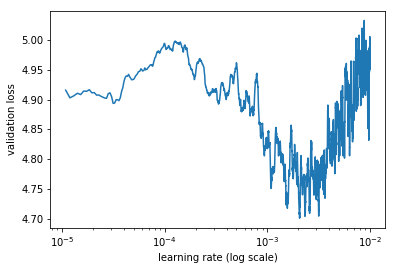

In [58]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)
learner.sched.plot()

In [59]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15, best_save_name='lm_best')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.623634   4.395445   0.251064  
    1      4.515604   4.327787   0.257414                                                                              
    2      4.431191   4.282779   0.261969                                                                              
    3      4.444696   4.255936   0.26505                                                                               
    4      4.374845   4.236597   0.267396                                                                              
    5      4.362561   4.218336   0.269405                                                                              
    6      4.355756   4.204825   0.270774                                                                              
    7      4.296858   4.194668   0.272005                                                                           

[array([4.13873]), 0.2787746596794862]

In [61]:
learner.save('lm1')

In [62]:
learner.save_encoder('lm1_enc')

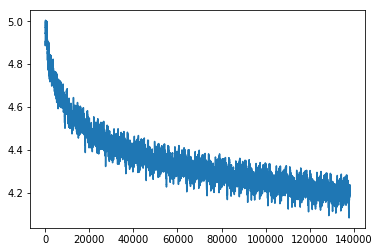

In [63]:
learner.sched.plot_loss()

In [29]:
learner.load('lm1')

In [30]:
learner.fit(lrs/10, 1, wds=wd, use_clr=(20,10), cycle_len=15, best_save_name='lm_best2')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.194851   4.139142   0.278875  
    1      4.227002   4.139499   0.278731                                                                              
    2      4.238202   4.137      0.279102                                                                              
    3      4.221786   4.13757    0.279278                                                                              
    4      4.186415   4.136888   0.279223                                                                              
    5      4.197328   4.135403   0.279349                                                                              
    6      4.221064   4.132761   0.279606                                                                              
    7      4.248554   4.132805   0.279704                                                                           

[array([4.13013]), 0.2802080370915624]

I decided to stop training here, mostly due to time. While the model hasn't overfit, it hasn't improved much in the last 15 epochs. I think I could push this model further by reducing the dropout and continuing with training, but I need the compute power for other projects.

Even though the model hasn't reached an optimum point, it has a better validation loss than the from scratch model in less time. That goes to show what can be accomplished with transfer learning.

In [32]:
learner.save('lm2')

In [33]:
learner.save_encoder('lm2_enc')

Lets have the model generate some text:

In [34]:
def sample_model(m, s, l=50):
    s_toks = Tokenizer().proc_text(s)
    s_nums = [stoi[i] for i in s_toks]
    s_var = V(np.array(s_nums))[None]
    
    m[0].bs=1
    m.eval()
    m.reset()
    
    res, *_ = m(s_var)
    print('...', end='')
    
    for i in range(l):
        r = torch.multinomial(res[-1].exp(), 2)
        #r = torch.topk(res[-1].exp(), 2)[1]
        if r.data[0] == 0:
            r = r[1]
        else:
            r = r[0]
            
        word = itos[to_np(r)[0]]
        res, *_ = m(r[0].unsqueeze(0))
        print(word, end=' ')
    m[0].bs=bs

In [35]:
m = learner.model

In [36]:
ss = 'Wrong '

In [37]:
sample_model(m, ss, l=500)

C:\Users\GATEWAY\Anaconda2\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
C:\Users\GATEWAY\Anaconda2\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


...? * cynical dance * you should like to hear this from me ... is this a threat that you arenât " a trumpet " or anything like that ? just think of the clock , if you are quietly watching it misspelled . 
 


	 
  respect to space tells people why they read it this way , how it responds , what makes life difficult for people . states the all regret knowing what result is a api , about what goes on on the memorized ( which are 95 % of the time gemini , and you got ta know a little more more than he did meant to say , too ) , and when youâre done thinking about it . i ¦ the rest of the logic is stated in the movie " the day after tomorrow " is it for tiffy or sympathy ? do you want the special chick to like you ? 
 


	 
  to see why no one can get any one ! in short ! it is far , far away . i have my first attempt at writing a blog hop day . i 'm on vacation , but it 's become a bitch . as i wanted to say , this blog is out of the ordinary . i have decided to stalking two people ju

The text is more fluent than the from scratch model. It has also adopted the format of most of the blog posts - paragraphs of text punctuated by several new lines. Interesting to see that a word like "dragonlance" made it into the top 60000 most used words.

# 4. Text Classification

So now we use our language model for classification. We do this by replacing the decoder in the language model with two fully connected layers that output a single prediction.

In [38]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [39]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [40]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [10]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [11]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [42]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [43]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

In [12]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [13]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [14]:
bptt,em_sz,nh,nl = 42,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 24

In [15]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [16]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [18]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.75

In [19]:
m = get_rnn_classifer(bptt, 15*42, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [20]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [21]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [22]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [23]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [24]:
wd = 1e-7
wd = 0
learn.load_encoder('lm2_enc')

The classification model adds an additional linear layer that ouputs 2 features for binary classification

In [25]:
learn

SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=50, bias=True)
        (drop): Dropout(p=0.30000000000000004)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=50, out_features=2, bias=True)
        (drop): Dropout(p=0.1)
        

In [57]:
learn.freeze_to(-1)

 78%|███████████████████████████████████████████████████▉               | 1121/1445 [19:14<05:33,  1.03s/it, loss=2.26]

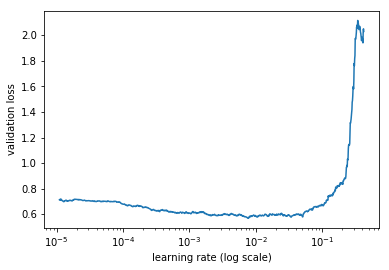

In [58]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [59]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.568549   0.535161   0.738516  


[array([0.53516]), 0.7385159015565254]

In [60]:
learn.save('clas_0')

In [61]:
learn.load('clas_0')

In [26]:
learn.freeze_to(-2)

In [63]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.527593   0.521161   0.733468  


[array([0.52116]), 0.733467946474989]

In [64]:
learn.save('clas_1')

In [27]:
learn.load('clas_1')

In [28]:
learn.unfreeze()

In [29]:
learn.fit(lrs, 1, wds=wd, cycle_len=7, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.537315   0.609173   0.688036  
    1      0.504965   0.487816   0.762746                                                                              
    2      0.484944   0.46364    0.772337                                                                              
    3      0.445489   0.464005   0.771832                                                                              
    4      0.419165   0.46587    0.778395                                                                              
    5      0.413076   0.473687   0.77688                                                                               
    6      0.405047   0.474997   0.774861                                                                              



[array([0.475]), 0.7748611792056985]

In [30]:
learn.save('clas_2')

# Conclusions

Without pretraining the classifier failed to improve beyond 50% accuracy. Starting with a pretrained model gets us to 77% accuracy!